In [6]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path

In [7]:
path = Path.cwd()
data_path = path /'data'
train_path = data_path /'MINDsmall_train'

In [8]:
behavior = pd.read_table(train_path/'behaviors.tsv',
                         header=None,
                         names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

news = pd.read_table(train_path/'news.tsv',
                     header=None,
                     names=['id', 'category', 'subcategory', 'title', 'abstract', 'url',
                            'title_entities', 'abstract_entities'])


entity_embedding = pd.read_table(train_path/'entity_embedding.vec', header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0, 'vector']].rename(columns={0: "entity"})


relation_embedding = pd.read_table(train_path/'relation_embedding.vec', header=None)
relation_embedding['vector'] = relation_embedding.iloc[:,1:101].values.tolist()
relation_embedding = relation_embedding[[0, 'vector']].rename(columns={0: "relation"})

In [9]:
behavior['time'] = pd.to_datetime(behavior['time'], format = "%m/%d/%Y %I:%M:%S %p")
print('Time Min and Max : {} - {}'.format(behavior['time'].min(), behavior['time'].max()))

Time Min and Max : 2019-11-09 00:00:19 - 2019-11-14 23:59:13


In [10]:
behavior.head(2)

,impression_id,user_id,time,history,impressions
0,1,U7615,2019-11-09 21:28:47,N61901 N28165 N5994 N32458 N30740 N63732 N2290...,N57352-0 N37113-0 N15218-0 N63863-0 N54656-0 N...
1,2,U19710,2019-11-09 00:02:50,N24199 N45678 N38206 N32830 N34257 N65070 N320...,N606-0 N35775-0 N42854-0 N592-0 N19156-0 N3724...


In [11]:
def count_impressions(impression_string):
    user_imp_list = impression_string.split()
    impression_length = len(user_imp_list)
    articles, clicked = [], []
    for i in range(impression_length):
        split = user_imp_list[i].split('-')
        articles.append(split[0])
        clicked.append(int(split[1]))
    
    num_clicked = sum(clicked)
    return(impression_length, num_clicked)

def count_history(history_string):
    user_history_list = history_string.split()
    return(len(user_history_list))

In [12]:
  behavior[['num_impressions', 'impressions_clicked']] = \
    pd.DataFrame(
        behavior['impressions'].apply(
            lambda x: count_impressions(x)).tolist(), 
            index = behavior.index)

behavior['history'] = behavior['history'].apply(lambda x: x.split() if type(x) == str else x)
behavior['impressions'] = behavior['impressions'].apply(lambda x: x.split())

In [13]:
# article_groupings, click_groupings = [], []
# for imp in behavior['impressions']:
#     temp = split_impression_string(impression = imp)
#     article_groupings.append(temp[0])
#     click_groupings.append(temp[1])

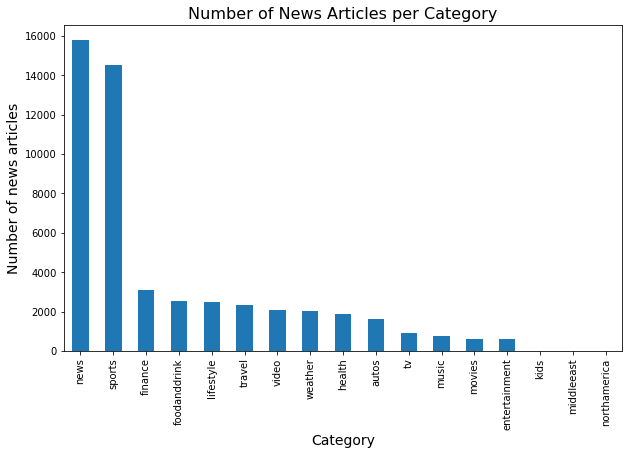

In [14]:
news['category'].value_counts().plot.bar(figsize = (10, 6))
plt.xlabel('Category', fontsize = 14)
plt.ylabel('Number of news articles', fontsize = 14)
plt.title('Number of News Articles per Category', fontsize = 16)
plt.show()

At a high level, the probability of an impression, $a_{ij} \in A_j$, being clicked given user $u_i$ and set of articles $A$, $P(C = 1|U = u_i)$, is a factor of: <br>
1. **Popularity of the article** - Good articles from reputed sources have higher chance of being clicked <br>
2. **User Preferences** - Different users have have different preferences for news articles <br>
3. **Choice of other articles shown** - Data is such that user would pick the best article among a set of candidates <br>
